In [5]:
import numpy as np
from numpy import random
from tqdm import tqdm
from autograd import grad 
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
dt = 0.01
time_horizon = 1000
num_steps = int(time_horizon/dt)

num_trajectories = 100

noise = random.normal(loc=0.0, scale=dt**(1/2), size=(num_trajectories, num_steps))

In [3]:
x_init = 0
jump_mult = 3
t = np.linspace(0, time_horizon, num_steps)
epsilon = (4.29 * 2 / np.log(time_horizon)) * jump_mult

In [6]:
def d_poly__d_x(x, t, period=100):
    a1 = 0
    a2 = -3.2
    sin_scale = 3
    a3 = sin_scale*np.sin(2*np.pi*t/period)
    a4 = 0.1
    a5 = -(3/5) * a3
    a6 = 1

    all_scale = 1.13
    
    return all_scale*(a6*6*x**5 + a5*5*x**4 + a4*4*x**3 + a3*3*x**2 + a2*2*x + a1)

def mu(x, t):
    return -d_poly__d_x(x, t)

def sigma(x, t):
    return epsilon ** (1/2)

dt values: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


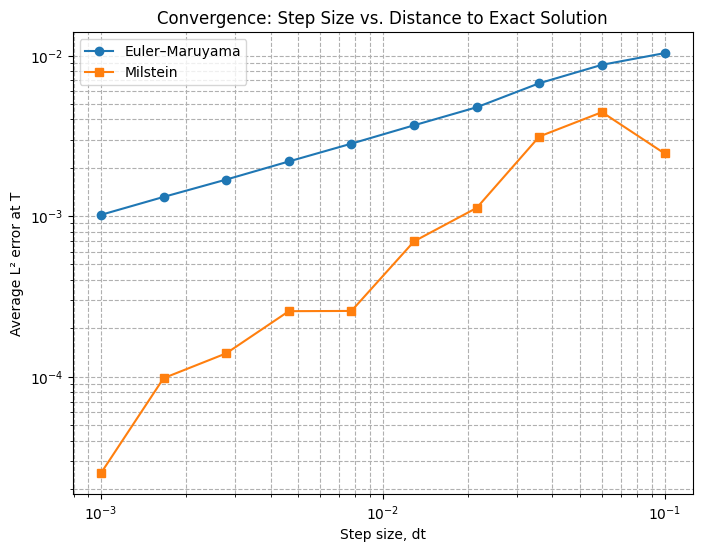

In [25]:
a = 0.1       # drift coefficient
b = 0.2       # diffusion coefficient
T = 1.0       # final time
x0 = 1.0      # initial condition

num_trajectories = 1000
num_simulations  = 50   

def generate_noise(dt, T, num_trajectories):
    num_steps = int(T / dt) + 1
    dW = np.sqrt(dt) * np.random.randn(num_steps - 1, num_trajectories)
    W = np.zeros((num_steps, num_trajectories))
    W[1:] = np.cumsum(dW, axis=0)
    return W

def euler_maruyama(dt, T, x0, noise):
    num_steps = noise.shape[0]
    x = np.zeros((num_steps, noise.shape[1]))
    x[0] = x0
    for i in range(num_steps - 1):
        dW = noise[i+1] - noise[i]
        x[i+1] = x[i] + a * x[i] * dt + b * x[i] * dW
    return x

def milstein(dt, T, x0, noise):
    num_steps = noise.shape[0]
    x = np.zeros((num_steps, noise.shape[1]))
    x[0] = x0
    for i in range(num_steps - 1):
        dW = noise[i+1] - noise[i]
        x[i+1] = x[i] + a * x[i] * dt + b * x[i] * dW \
                 + 0.5 * (b**2) * x[i] * (dW**2 - dt)
    return x

def exact_solution(T, x0, noise):
    return x0 * np.exp((a - 0.5 * b**2) * T + b * noise[-1])

def compute_rmse(numerical, exact):
    return np.sqrt(np.mean((numerical - exact)**2))


dt_values = np.logspace(-3, -1, num=10)

errors_euler   = []
errors_milstein = []

for dt in tqdm(dt_values, desc="dt values"):
    euler_errors   = []
    milstein_errors = []
    
    for _ in range(num_simulations):
        noise = generate_noise(dt, T, num_trajectories)
        
        x_euler   = euler_maruyama(dt, T, x0, noise)
        x_milstein = milstein(dt, T, x0, noise)
        
        x_exact = exact_solution(T, x0, noise)
        
        err_euler   = compute_rmse(x_euler[-1], x_exact)
        err_milstein = compute_rmse(x_milstein[-1], x_exact)
        
        euler_errors.append(err_euler)
        milstein_errors.append(err_milstein)
    
    errors_euler.append(np.mean(euler_errors))
    errors_milstein.append(np.mean(milstein_errors))


plt.figure(figsize=(8, 6))
plt.loglog(dt_values, errors_euler, 'o-', label='Euler–Maruyama')
plt.loglog(dt_values, errors_milstein, 's-', label='Milstein')
plt.xlabel('Step size, dt')
plt.ylabel('Average L² error at T')
plt.title('Convergence: Step Size vs. Distance to Exact Solution')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
